In [1]:
#filename = r'C:/Data/Antonio/software/src/phconvert/notebooks/data/Pre.ht3'
filename = r'data/eitan/Pre.ht3'

In [2]:
run_id = 1

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tables

In [4]:
import phconvert as phc
phc.__version__

'0.5.3-7-gc062ec1'

In [5]:
import time

class Timer:
    def __init__(self, name):
        self.name = name
        
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start

# Author

In [6]:
author = 'Eitan Lerner'
author_affiliation = 'UCLA'
creator = 'Antonino Ingargiola'
creator_affiliation = 'UCLA'

# Sample

In [7]:
comment = 'A demostrative smFRET-nsALEX measurement.'
sample_name = 'Doubly-labeled ssDNA partially hybridized to a complementary strand.'
dye_names = 'ATTO488, ATTO647N'
buffer_name = 'Tris20 mM Ph 7.8'

# Prepare data

## Read the data

In [8]:
with Timer('pq_read_speed_native_numba') as t:
    timestamps, detectors, nanotimes, meta = phc.pqreader.load_ht3(filename)
    
read_speed_native_numpy_numba = pd.DataFrame({'native_numpy_numba': t.interval}, index=[0])
read_speed_native_numpy_numba

,native_numpy_numba
0,0.978359


In [9]:
with Timer('pq_read_speed_native') as t:
    timestamps, detectors, nanotimes, meta = phc.pqreader.load_ht3(filename, ovcfunc=phc.pqreader._correct_overflow2)

read_speed_native_numpy = pd.DataFrame({'native_numpy': t.interval}, index=[0])
read_speed_native_numpy

NOTE: You can speed-up the loading time by installing numba.


,native_numpy
0,37.274539


In [10]:
timestamps.size

20120771

In [11]:
(timestamps[-1]-timestamps[0])*50e-9

899.98510079999994

In [12]:
d, meta = phc.loader.nsalex_ht3(filename,
                                donor = 0,
                                acceptor = 1,
                                alex_period_donor = (150, 1500),
                                alex_period_acceptor = (1540, 3050),
                                excitation_wavelengths = (470e-9, 635e-9),
                                detection_wavelengths = (525e-9, 690e-9),
                                time_reversed = False)

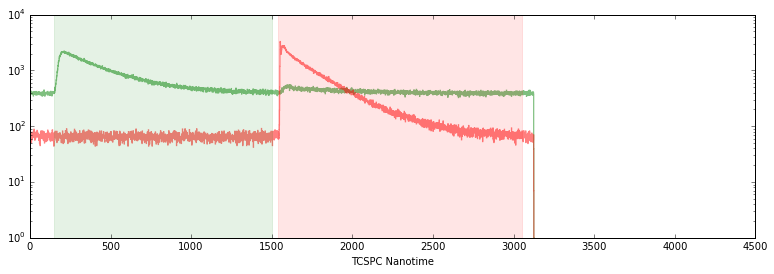

In [13]:
fig, ax = plt.subplots(figsize=(13, 4))
phc.plotter.alternation_hist(d, ax=ax)

In [14]:
detectors = d['photon_data']['detectors']
print('Detector numbers: ', np.unique(detectors))

('Detector numbers: ', array([  0,   1, 127], dtype=uint8))


In [15]:
print("Detector    Counts")
print("--------   --------")
for det, count in zip(*np.unique(detectors, return_counts=True)):
    print("%8d   %8d" % (det, count))

Detector    Counts
--------   --------
       0    1788207
       1     754729
     127   17577835


## Add author and sample info

In [16]:
d['comment'] = comment

d['sample'] = dict(
    sample_name=sample_name,
    dye_names=dye_names,
    buffer_name=buffer_name,
    num_dyes = len(dye_names.split(',')))

d['identity'] = dict(
    author=author,
    author_affiliation=author_affiliation,
    creator=creator,
    creator_affiliation=creator_affiliation)

# Validate the Photon-HDF5 structure

Before writing to disk, we assure the file structure follows the Photon-HDF5 format:

In [17]:
phc.hdf5.assert_valid_photon_hdf5(d)

# Save to Photon-HDF5

In [18]:
write_speed_ = {}
file_size_ = {}
for complib in ['zlib', 'blosc']:
    for complevel in range(0, 10):
        compression = {'complevel': complevel, 'complib': complib}
        fn = "%s_%s%d.hdf5" % (filename[:-4], complib, complevel)
        print (fn)
        with Timer(fn) as t:
            phc.hdf5.save_photon_hdf5(d, close=True, h5_fname=fn, compression=compression)
        write_speed_[(complib, complevel)] = t
        file_size_[(complib, complevel)] = os.path.getsize(fn)

data/eitan/Pre_zlib0.hdf5
Saving: data/eitan/Pre_zlib0.hdf5
data/eitan/Pre_zlib1.hdf5
Saving: data/eitan/Pre_zlib1.hdf5
data/eitan/Pre_zlib2.hdf5
Saving: data/eitan/Pre_zlib2.hdf5
data/eitan/Pre_zlib3.hdf5
Saving: data/eitan/Pre_zlib3.hdf5
data/eitan/Pre_zlib4.hdf5
Saving: data/eitan/Pre_zlib4.hdf5
data/eitan/Pre_zlib5.hdf5
Saving: data/eitan/Pre_zlib5.hdf5
data/eitan/Pre_zlib6.hdf5
Saving: data/eitan/Pre_zlib6.hdf5
data/eitan/Pre_zlib7.hdf5
Saving: data/eitan/Pre_zlib7.hdf5
data/eitan/Pre_zlib8.hdf5
Saving: data/eitan/Pre_zlib8.hdf5
data/eitan/Pre_zlib9.hdf5
Saving: data/eitan/Pre_zlib9.hdf5
data/eitan/Pre_blosc0.hdf5
Saving: data/eitan/Pre_blosc0.hdf5
data/eitan/Pre_blosc1.hdf5
Saving: data/eitan/Pre_blosc1.hdf5
data/eitan/Pre_blosc2.hdf5
Saving: data/eitan/Pre_blosc2.hdf5
data/eitan/Pre_blosc3.hdf5
Saving: data/eitan/Pre_blosc3.hdf5
data/eitan/Pre_blosc4.hdf5
Saving: data/eitan/Pre_blosc4.hdf5
data/eitan/Pre_blosc5.hdf5
Saving: data/eitan/Pre_blosc5.hdf5
data/eitan/Pre_blosc6.hdf5
S

In [19]:
t_blosc = [write_speed_[key].interval for key in sorted(write_speed_.keys())if key[0] == 'blosc']
t_zlib = [write_speed_[key].interval for key in sorted(write_speed_.keys())if key[0] == 'zlib']

size_blosc = [file_size_[key] for key in sorted(file_size_.keys())if key[0] == 'blosc']
size_zlib = [file_size_[key] for key in sorted(file_size_.keys())if key[0] == 'zlib']

In [20]:
write_speed = pd.DataFrame({'zlib': t_zlib, 'blosc': t_blosc})
file_size = pd.DataFrame({'zlib': size_zlib, 'blosc': size_blosc})
file_size['native'] = os.path.getsize(filename)

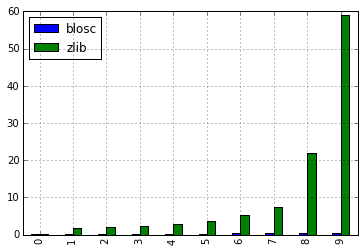

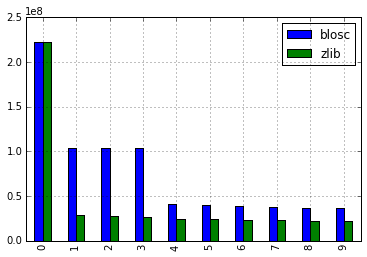

In [21]:
write_speed.plot(kind='bar')
file_size.plot(kind='bar')

(0, 1)

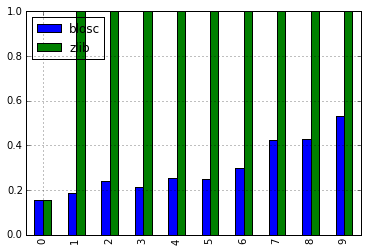

In [22]:
write_speed.plot(kind='bar')
plt.ylim(0, 1)

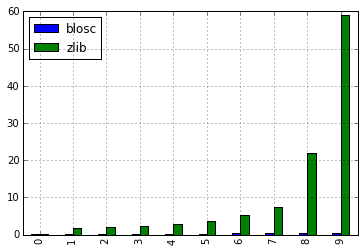

In [23]:
write_speed.plot(kind='bar')

(0, 1)

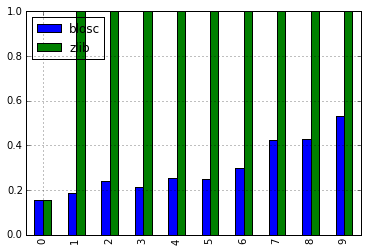

In [24]:
write_speed.plot(kind='bar')
plt.ylim(0, 1)

In [ ]:
write_speed.to_hdf('benchmark%d.h5' % run_id, key='ht3_write_speed')

In [39]:
file_size.to_hdf('benchmark%d.h5' % run_id, key='ht3_file_size')

# Read speed

In [26]:
read_speed_ = {}
cache = []
for complib in ['zlib', 'blosc']:
    for complevel in range(9, -1, -1):
        fn = "%s_%s%d.hdf5" % (filename[:-4], complib, complevel)
        print (fn)
        assert os.path.exists(fn)
        with Timer(fn) as t:
            
            with tables.open_file(fn) as h5:
                a = h5.root.photon_data.timestamps.read()
                b = h5.root.photon_data.detectors.read()
                c = h5.root.photon_data.nanotimes.read()
        
        cache.append((a,b,c))
        read_speed_[(complib, complevel)] = t
del cache

data/eitan/Pre_zlib9.hdf5
data/eitan/Pre_zlib8.hdf5
data/eitan/Pre_zlib7.hdf5
data/eitan/Pre_zlib6.hdf5
data/eitan/Pre_zlib5.hdf5
data/eitan/Pre_zlib4.hdf5
data/eitan/Pre_zlib3.hdf5
data/eitan/Pre_zlib2.hdf5
data/eitan/Pre_zlib1.hdf5
data/eitan/Pre_zlib0.hdf5
data/eitan/Pre_blosc9.hdf5
data/eitan/Pre_blosc8.hdf5
data/eitan/Pre_blosc7.hdf5
data/eitan/Pre_blosc6.hdf5
data/eitan/Pre_blosc5.hdf5
data/eitan/Pre_blosc4.hdf5
data/eitan/Pre_blosc3.hdf5
data/eitan/Pre_blosc2.hdf5
data/eitan/Pre_blosc1.hdf5
data/eitan/Pre_blosc0.hdf5


In [27]:
#h5 = tables.open_file('data/eitan/Pre.hdf5')

In [28]:
# h5.root.photon_data.timestamps.chunkshape
# h5.root.photon_data.detectors.chunkshape
# h5.root.photon_data.nanotimes.chunkshape
# h5.root.photon_data.timestamps.size_in_memory
# h5.root.photon_data.timestamps.size_on_disk

In [29]:
t_blosc = [read_speed_[key].interval for key in sorted(read_speed_.keys())if key[0] == 'blosc']
t_zlib = [read_speed_[key].interval for key in sorted(read_speed_.keys())if key[0] == 'zlib']

In [30]:
read_speed = pd.DataFrame({'zlib': t_zlib, 'blosc': t_blosc})

In [31]:
read_speed = read_speed.join(read_speed_native_numpy)
read_speed = read_speed.join(read_speed_native_numpy_numba)

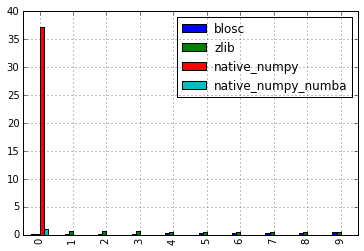

In [32]:
read_speed.plot(kind='bar')

(0, 1.2)

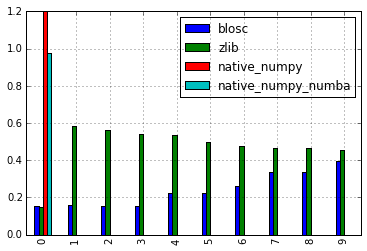

In [33]:
read_speed.plot(kind='bar')
plt.ylim(0, 1.2)

(0, 1.2)

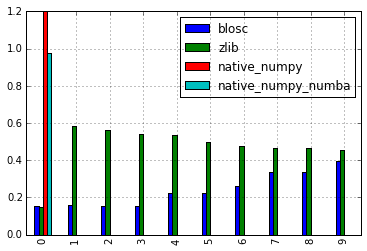

In [34]:
read_speed.plot(kind='bar')
plt.ylim(0, 1.2)

(0, 1.2)

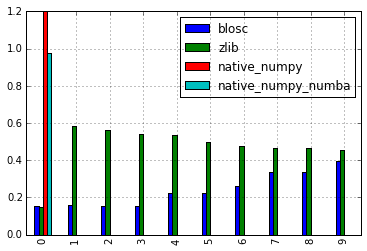

In [35]:
read_speed.plot(kind='bar')
plt.ylim(0, 1.2)

In [36]:
read_speed

,blosc,zlib,native_numpy,native_numpy_numba
0,0.154712,0.148167,37.274539,0.978359
1,0.155966,0.584412,NaN,NaN
2,0.153241,0.563229,NaN,NaN
3,0.152987,0.538936,NaN,NaN
4,0.225491,0.533664,NaN,NaN
5,0.224690,0.499392,NaN,NaN
6,0.262756,0.474334,NaN,NaN
7,0.333553,0.466075,NaN,NaN
8,0.333610,0.467009,NaN,NaN
9,0.393065,0.452551,NaN,NaN


In [37]:
read_speed.to_hdf('benchmark%d.h5' % run_id, key='ht3_read_speed')